# Visualize model content
## Setup
### Import packages

In [2]:
import textwrap
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rbc_gem_utils import (
    CURATION_PATH,
    DATABASE_PATH,
    GEM_NAME,
    PROCESSED_PATH,
    ROOT_PATH,
    build_string,
    get_annotation_df,
    read_rbc_model,
    show_versions,
    split_string,
)
from rbc_gem_utils.database import TCDB_PATH
from rbc_gem_utils.visualization import cmap_map

# Display versions of last time notebook ran and worked
show_versions()
plt.rcParams["font.family"] = "Arial"


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Load RBC-GEM model

In [3]:
# Use XML for groups
model = read_rbc_model(filetype="xml")
model

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-21


Name,RBC_GEM
Memory address,152dc1e10
Number of metabolites,2157
Number of reactions,3277
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Categorize reactions by KEGG Pathways

In [4]:
# Turned into an xlsx where keys are sheet names and values are DataFrames representing the sheet
all_figure_data = {}
imagetype = "svg"
transparent = True
save_figures = True

results_path = ROOT_PATH / PROCESSED_PATH / model.id / "ModelContentOverview"
results_path.mkdir(exist_ok=True, parents=True)

### Load pathway mappings

In [5]:
df_pathways = pd.read_csv(
    ROOT_PATH / CURATION_PATH / "subsystems.tsv", sep="\t", index_col=0, dtype=str
)
df_pathways = df_pathways.fillna("").reset_index()
all_figure_data["PathwayMapping"] = df_pathways.copy()
# Group "Metabolism of other amino acids" with amino acids rather than treat as "other"
df_pathways["category"] = df_pathways["category"].replace(
    "Metabolism of other amino acids", "Amino acid metabolism"
)
df_pathways

,name,category,kegg.pathway.name,kegg.pathway,notes
0,"Alanine, aspartate and glutamate metabolism",Amino acid metabolism,"Alanine, aspartate and glutamate metabolism",hsa00250,
1,Arginine and proline metabolism,Amino acid metabolism,Arginine and proline metabolism,hsa00330,
2,Cysteine and methionine metabolism,Amino acid metabolism,Cysteine and methionine metabolism,hsa00270,
3,"Glycine, serine and threonine metabolism",Amino acid metabolism,"Glycine, serine and threonine metabolism",hsa00260,
4,Histidine metabolism,Amino acid metabolism,Histidine metabolism,hsa00340,
...,...,...,...,...,...
73,Aminoacyl-tRNA biosynthesis,Translation,Aminoacyl-tRNA biosynthesis,has00970,
74,"Transport, extracellular",Transport reactions,,,Representative subsystem for all transport rea...
75,5-fluorouracil metabolism,Xenobiotics biodegradation and metabolism,Drug metabolism - other enzymes,hsa00983,"Subnetwork of KEGG pathway ""Drug metabolism - ..."
76,Azathioprine and 6-mercaptopurine metabolism,Xenobiotics biodegradation and metabolism,Drug metabolism - other enzymes,hsa00983,"Subnetwork of KEGG pathway ""Drug metabolism - ..."


### Visualization options

In [6]:
# Categories that should be excluded from the figure
categories_to_exclude = {"Pseudoreactions", "Model total"}
# Main categories in figure and abbreviations, all unmapped categories are mapped to "Other"
categories_to_keep = {
    "Amino acid metabolism": mpl.cm.spring,
    "Carbohydrate metabolism": mpl.cm.Greens,
    "Lipid metabolism": mpl.cm.Blues,
    "Metabolism of cofactors and vitamins": mpl.cm.summer,
    "Nucleotide metabolism": mpl.cm.winter,
    "Reactive species": mpl.cm.Reds,
    "Transport reactions": mpl.cm.Purples,
    "Other": mpl.cm.gray_r,
}
use_abbrevs = True
abbrevs = {
    "Amino acid metabolism": "A",
    "Carbohydrate metabolism": "C",
    "Lipid metabolism": "L",
    "Metabolism of cofactors and vitamins": "V",
    "Nucleotide metabolism": "N",
    "Reactive species": "R",
    "Transport reactions": "T",
    "Other": "O",
}
barsize = 0.8
cmax = 0.8
cmin = 0.15


colormaps_normal = dict(
    zip(
        categories_to_keep,
        [
            cmap_map(lambda x: x * 1, categories_to_keep[k])(cmax)
            for k in categories_to_keep
        ],
    )
)
colormaps_light = dict(
    zip(
        categories_to_keep,
        [
            cmap_map(lambda x: x / 2 + 0.5, categories_to_keep[k])(cmax)
            for k in categories_to_keep
        ],
    )
)

#### Create tables and individual figures

In [7]:
data = defaultdict(dict)
all_reactions = set()
df_cat_subsystems = df_pathways.groupby("category")["name"].agg(lambda x: list(x))
for category, subsystem_list in df_cat_subsystems.items():
    if category not in categories_to_keep and category not in categories_to_exclude:
        category = "Other"

    if category not in data:
        data[category] = {"Reactions": set(), "Metabolites": set(), "Genes": set()}
    reactions = [
        reaction
        for group in model.groups.get_by_any(subsystem_list)
        for reaction in group.members
    ]
    for reaction in reactions:
        all_reactions.update([reaction])
        data[category]["Reactions"].update([reaction])
        data[category]["Metabolites"].update(reaction.metabolites)
        data[category]["Genes"].update(reaction.genes)

data["Model total"] = {
    "Reactions": model.reactions,
    "Metabolites": model.metabolites,
    "Genes": model.genes,
}
df_data = pd.DataFrame(
    {
        key: {k: len(x) for k, x in value_dict.items()}
        for key, value_dict in data.items()
    }
).T.sort_index()

# Remove columns to exlcude:
for to_exclude in categories_to_exclude:
    del data[to_exclude]
df_data = df_data.sort_values("Reactions", ascending=False)
if use_abbrevs:
    df_data["abbrevs"] = abbrevs
all_figure_data["General"] = df_data.copy()
df_data

,Reactions,Metabolites,Genes,abbrevs
Model total,3277,2157,820,NaN
Transport reactions,876,890,150,T
Lipid metabolism,711,740,106,L
Pseudoreactions,552,670,0,NaN
Amino acid metabolism,281,276,100,A
Other,232,362,238,O
Carbohydrate metabolism,210,207,148,C
Nucleotide metabolism,172,146,127,N
Metabolism of cofactors and vitamins,140,176,69,V
Reactive species,103,127,37,R


### Subsystems

In [10]:
df_subsystem_data = defaultdict(dict)
reactions = set()
idx = 0
for category, subsystem_list in df_cat_subsystems.items():
    if category in categories_to_exclude:
        continue
    if category not in categories_to_keep:
        category = "Other"

    for group in model.groups.get_by_any(subsystem_list):
        df_subsystem_data[idx]["name"] = group.name
        df_subsystem_data[idx]["category"] = category
        df_subsystem_data[idx]["size"] = len(group.members)
        reactions.update(group.members)
        idx += 1
df_subsystem_data = pd.DataFrame.from_dict(df_subsystem_data, orient="index")
# QC check: Ensure mappings worked correctly and there is a color per category
# QC check Total number of reactions (excluding pseudoreactions) match sum of the group sizes
assert (
    len(model.reactions.query(lambda x: not x.subsystem == "Pseudoreactions"))
    == df_subsystem_data["size"].sum()
)
df_subsystem_data = df_subsystem_data.sort_values(
    by=["category", "size"], ascending=[True, False]
).reset_index(drop=True)
all_figure_data["Subsystem Sizes"] = df_subsystem_data.copy()

# Set colors
df_subsystem_data_color = df_subsystem_data.set_index("name")
colors = {}
for category, (names, size) in (
    df_subsystem_data.groupby(["category"])
    .agg({"name": lambda x: list(x), "size": "size"})
    .iterrows()
):
    colors.update(
        dict(
            zip(
                names, categories_to_keep[category](np.linspace(cmax - 0.1, cmin, size))
            )
        )
    )
df_subsystem_data_color["color"] = colors
df_subsystem_data_color = df_subsystem_data_color.reset_index(drop=False)
df_subsystem_data_color

Amino acid metabolism
Carbohydrate metabolism
Lipid metabolism
Metabolism of cofactors and vitamins
Nucleotide metabolism
Other
Reactive species
Transport reactions


,category,size
name,,
"Phenylalanine, tyrosine and tryptophan metabolism",Amino acid metabolism,133
Cysteine and methionine metabolism,Amino acid metabolism,45
Arginine and proline metabolism,Amino acid metabolism,32
"Glycine, serine and threonine metabolism",Amino acid metabolism,19
Glutathione metabolism,Amino acid metabolism,17
...,...,...
N-glycan metabolism,Other,1
Reactive species formation and detoxification,Reactive species,58
Hemoglobin binding and degradation,Reactive species,32


In [13]:
df_category_data = df_subsystem_data.groupby("category")["size"].sum()
assert df_category_data.nunique() == len(categories_to_keep)
if use_abbrevs:
    df_category_data = pd.concat(
        (df_category_data, pd.Series(abbrevs, name="abbrev")), axis=1
    )
    df_category_data.index.name = "category"
df_category_data = df_category_data.sort_index(ascending=True).reset_index(drop=False)
all_figure_data["Category Sizes"] = df_data.copy()
# # # Add colors to table
df_category_data_color = df_category_data.set_index("category")
df_category_data_color["color"] = {
    key: tuple(value(cmax)) for key, value in categories_to_keep.items()
}
df_category_data_color = df_category_data_color.reset_index(drop=False)
df_category_data_color

,category,size
0,Amino acid metabolism,281
1,Carbohydrate metabolism,210
2,Lipid metabolism,711
3,Metabolism of cofactors and vitamins,140
4,Nucleotide metabolism,172
5,Other,232
6,Reactive species,103
7,Transport reactions,876


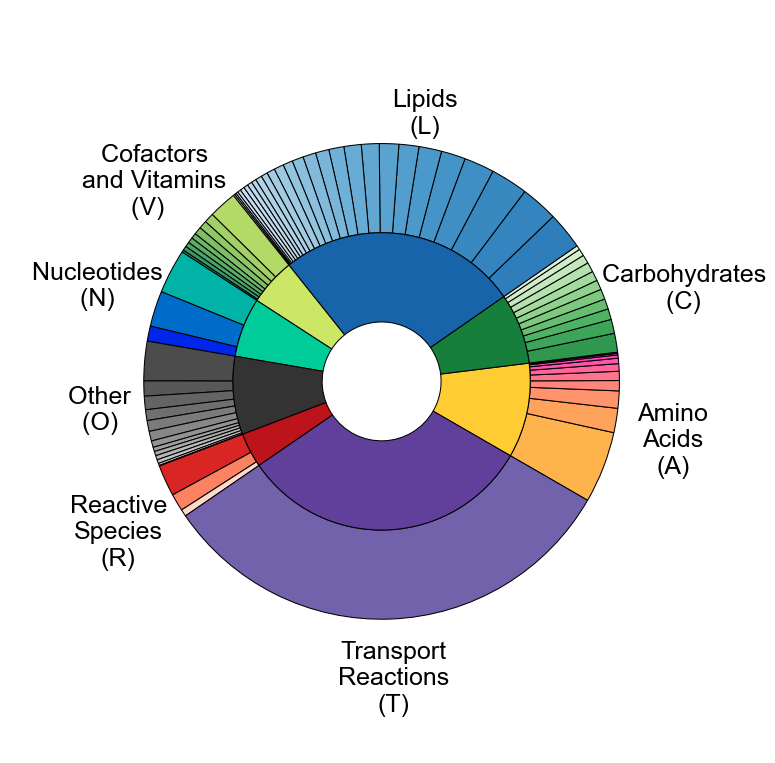

In [9]:
df_ring0, df_ring1 = df_category_data_color, df_subsystem_data_color

fig_ring, ax_ring = plt.subplots(1, 1, figsize=(8, 8))

wedgesize = 0.3
radius = 0.5
startangle = -30
ring_idx = 1
linewidth = 0.75
edgecolor = "k"
wedges, labels = ax_ring.pie(
    df_ring1["size"].values,
    radius=radius + (ring_idx * wedgesize),
    colors=df_ring1["color"].values,
    # labels=df_ring1["name"].values,
    wedgeprops=dict(
        width=wedgesize, linewidth=linewidth, edgecolor=edgecolor, clip_on=False
    ),
    textprops={"fontsize": "large"},
    startangle=startangle,
)

ring_idx = 0

# Use for nice legend
legend_labels_dict = {
    "Amino acid metabolism": "Amino\nAcids\n(A)",
    "Carbohydrate metabolism": "\n       Carbohydrates\n       (C)",
    "Lipid metabolism": "\n\nLipids\n(L)",
    "Metabolism of cofactors and vitamins": "Cofactors  \nand Vitamins  \n(V)    ",
    "Nucleotide metabolism": "\nNucleotides  \n(N)  ",
    "Other": "    Other\n    (O)",
    "Reactive species": "\nReactive\nSpecies\n(R)",
    "Transport reactions": "Transport\nReactions\n(T)",
}
wedges, labels = ax_ring.pie(
    df_ring0["size"].values,
    radius=radius + (ring_idx * wedgesize),
    colors=df_ring0["color"].values,
    labels=[f"{legend_labels_dict[x]}" for x in df_ring0["category"].values],
    wedgeprops=dict(
        width=wedgesize, linewidth=linewidth, edgecolor=edgecolor, clip_on=False
    ),
    textprops={"fontsize": 18, "va": "center", "ha": "center"},
    startangle=startangle,
    labeldistance=2.0,
)

fig_ring.tight_layout()
if save_figures:
    fig_ring.savefig(
        results_path / f"ModelContent_PanelA.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

#### Transporter categorized

In [10]:
database_dirpath = ROOT_PATH / DATABASE_PATH / TCDB_PATH

df_tcdb_data = pd.read_csv(
    database_dirpath / f"TCDB_{GEM_NAME}.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
).fillna("")
df_tcdb_data = df_tcdb_data.loc[
    :, ["tcdb", "subfamily", "family", "subclass", "class", "fam_name"]
].drop_duplicates()

groupby_key = "class"
groupby_regex = {
    "class": r"^\w+",
    "subclass": r"^\w+\W\w+",
    "family": r"^\w+\W\w+\W\w+",
    "subfamily": r"^\w+\W\w+\W\w+\W\w+",
    "tcdb": r"^\w+\W\w+\W\w+\W\w+\W\w+",
}[groupby_key]

tcdb_mappings = {
    "class": {
        "1": "Channels/Pores",
        "2": "Electrochemical Potential-driven Transporters",
        "3": "Primary Active Transporters",
        "4": "Group Translocators",
        "5": "Transmembrane Electron Carriers",
        "8": "Accessory Factors Involved in Transport",
        "9": "Incompletely Characterized Transport Systems",
    },
    "subclass": {},
    "family": df_tcdb_data.set_index("family")["fam_name"]
    .replace("", float("nan"))
    .dropna()
    .drop_duplicates()
    .to_dict(),
    "subfamily": {},
}[groupby_key]

df_tcdb_data

,tcdb,subfamily,family,subclass,class,fam_name
0,3.A.1.211.14,3.A.1.211,3.A.1,3.A,3,The ATP-binding Cassette (ABC) Superfamily
1,3.A.1.211.10,3.A.1.211,3.A.1,3.A,3,The ATP-binding Cassette (ABC) Superfamily
2,3.A.1.201.1,3.A.1.201,3.A.1,3.A,3,The ATP-binding Cassette (ABC) Superfamily
3,3.A.1.201.3,3.A.1.201,3.A.1,3.A,3,The ATP-binding Cassette (ABC) Superfamily
4,3.A.1.210.6,3.A.1.210,3.A.1,3.A,3,The ATP-binding Cassette (ABC) Superfamily
...,...,...,...,...,...,...
160,1.A.4.1.5,1.A.4.1,1.A.4,1.A,1,The Transient Receptor Potential Ca2+/Cation C...
161,1.A.4.2.8,1.A.4.2,1.A.4,1.A,1,The Transient Receptor Potential Ca2+/Cation C...
162,9.A.24.1.17,9.A.24.1,9.A.24,9.A,9,The Mitochondrial Cholesterol/Porphyrin/5-amin...
164,1.B.8.1.12,1.B.8.1,1.B.8,1.B,1,The Mitochondrial and Plastid Porin (MPP) Family


In [11]:
transport_reactions = model.reactions.query(
    lambda x: x in data["Transport reactions"]["Reactions"]
)

df_transport_reactions = pd.DataFrame(
    {"genes": {r.id: {g.id for g in list(r.genes)} for r in transport_reactions}}
)
df_transport_reactions.index.name = "reactions"
df_transport_reactions = df_transport_reactions.explode("genes").reset_index(drop=False)


df_model_genes = get_annotation_df(model.genes, ["ncbigene", "tcdb"]).rename(
    {"id": "genes"}, axis=1
)
df_model_genes = df_model_genes[df_model_genes["tcdb"].notna()]
df_model_genes["tcdb"] = df_model_genes["tcdb"].apply(
    lambda x: split_string(x) if isinstance(x, str) else x
)
df_model_genes = df_model_genes.explode("tcdb")
df_model_genes = df_model_genes.sort_values(by="tcdb").reset_index(drop=True)

df_transport_reactions = (
    df_transport_reactions.merge(
        df_model_genes, left_on="genes", right_on="genes", how="left"
    )
    .merge(df_tcdb_data, left_on="tcdb", right_on="tcdb", how="left")
    .drop_duplicates()
)


df_transport_reactions = df_transport_reactions.loc[
    :, ["reactions", "genes", "tcdb", "subfamily", "family", "subclass", "class"]
]
df_transport_reactions = df_transport_reactions.drop_duplicates()
df_transport_reactions = df_transport_reactions.copy()

df_transport_reactions[groupby_key] = (
    df_transport_reactions["tcdb"].str.findall(groupby_regex).explode()
)
df_transport_reactions[groupby_key] = df_transport_reactions[groupby_key].fillna(
    "Unclassified"
)
df_transport_reactions = pd.merge(
    df_transport_reactions.groupby(groupby_key)[["reactions", "genes"]].agg(
        lambda x: x.dropna().nunique()
    ),
    df_transport_reactions.groupby(groupby_key)[["reactions", "genes"]].agg(
        lambda x: build_string(x.dropna().unique())
    ),
    left_index=True,
    right_index=True,
    how="left",
    suffixes=("", ".ids"),
)
all_figure_data[f"Transporters_{groupby_key}"] = df_transport_reactions.reset_index(
    drop=False
).copy()
df_transport_reactions = df_transport_reactions.drop(
    labels=[c for c in df_transport_reactions.columns if c.endswith(".ids")], axis=1
).astype(int)
df_transport_reactions

,reactions,genes
class,,
1,37,27
2,523,57
3,79,29
4,68,2
5,5,2
8,410,6
9,98,7
Unclassified,257,24


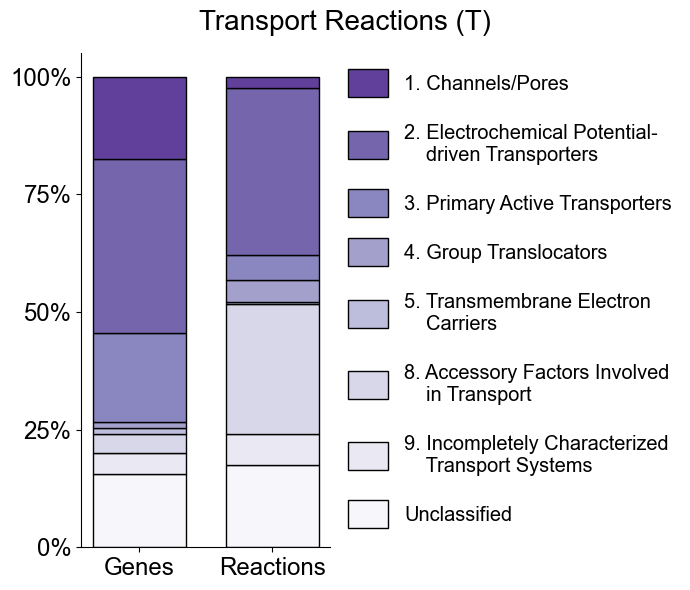

In [12]:
df = df_transport_reactions.copy()

barsize = 0.7
edgecolor = "black"
edgewidth = 1
columns = ["genes", "reactions"]
labels = df.index


totals = df.sum(axis=0)
df = round(df / totals * 100, 3)
df = df[::-1].T
df = df.loc[columns]

color_dict = dict(
    zip(
        labels,
        categories_to_keep["Transport reactions"](np.linspace(cmax, 0.05, len(labels))),
    )
)

fig_transport, ax_transport = plt.subplots(1, 1, figsize=(7, 6))
sns.despine(fig_transport)
offset = np.zeros(len(df.index))
for idx, (label, series) in enumerate(df.items()):
    rects = ax_transport.bar(
        [x.capitalize() for x in series.index],
        series.values,
        barsize,
        bottom=offset,
        color=color_dict[label],
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values
    # if idx == len(df.columns) - 1:
    #     ax.bar_label(rects, labels=totals.values, label_type='edge', color="black",  fmt='{:,.0f}', padding=1)


ticks = np.linspace(0, 100, 5)
ax_transport.set_yticks(ticks, [f"{v:.0f}%" for v in ticks])
ax_transport.set_yticklabels(
    ax_transport.get_yticklabels(), fontdict={"size": "xx-large"}
)
ax_transport.xaxis.set_tick_params(labelsize="xx-large")
fig_transport.suptitle("Transport Reactions (T)", fontsize=20, y=0.975)
legend = ax_transport.legend(
    handles=[
        mpl.patches.Patch(
            facecolor=color,
            label=tcdb_mappings.get(label, label),
            edgecolor=edgecolor,
            linewidth=edgewidth,
        )
        for label, color in color_dict.items()
    ],
    labels=[
        (
            "\n    ".join(
                textwrap.wrap(f"{label}. " + tcdb_mappings.get(label, label), 30)
            )
            if label != "Unclassified"
            else label
        )
        for label in list(color_dict)
    ],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize="x-large",
    labelspacing=1.5,
)
for patch in legend.get_patches():
    patch.set_height(20)
    patch.set_y(-5)
fig_transport.tight_layout()
if save_figures:
    fig_transport.savefig(
        results_path / f"ModelContent_PanelB.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Reaction content

In [13]:
df_reactions = defaultdict(dict)

for category in categories_to_keep:
    reactions = data[category]["Reactions"]
    gene_associated = {rxn for rxn in reactions if rxn.gene_reaction_rule}
    known_spontaneous = {
        rxn
        for rxn in reactions
        if int(float(rxn.annotation.get("spontaneous", 0)))
        and rxn not in gene_associated
    }
    unknown = {
        rxn
        for rxn in reactions
        if not rxn in gene_associated and not rxn in known_spontaneous
    }
    df_reactions[category]["Gene associated"] = len(gene_associated)
    df_reactions[category]["Spontaneous"] = len(known_spontaneous)
    df_reactions[category]["Unknown"] = len(unknown)
    df_reactions[category]["Total"] = len(reactions)

    df_reactions[category]["Gene associated.ids"] = build_string(
        sorted([x.id for x in gene_associated])
    )
    df_reactions[category]["Spontaneous.ids"] = build_string(
        sorted([x.id for x in known_spontaneous])
    )
    df_reactions[category]["Unknown.ids"] = build_string(
        sorted([x.id for x in unknown])
    )

df_reactions = pd.DataFrame.from_dict(df_reactions).T
if use_abbrevs:
    df_reactions["abbrevs"] = abbrevs
# QC check to ensure no reactions are missing
assert (
    df_reactions[["Gene associated", "Spontaneous", "Unknown"]].sum(axis=1)
    == df_reactions["Total"]
).all()
assert df_reactions["Total"].sum() == len(
    model.reactions.query(lambda x: not x.subsystem == "Pseudoreactions")
)
df_reactions = df_reactions.sort_values(by="Total", ascending=True)

all_figure_data["Reactions"] = df_reactions.copy()
df_reactions = df_reactions.drop(
    labels=[c for c in df_reactions.columns if c.endswith(".ids") or c == "abbrevs"],
    axis=1,
).astype(int)
df_reactions

,Gene associated,Spontaneous,Unknown,Total
Reactive species,64,31,8,103
Metabolism of cofactors and vitamins,115,11,14,140
Nucleotide metabolism,158,9,9,176
Carbohydrate metabolism,186,12,12,210
Other,208,19,5,232
Amino acid metabolism,198,38,45,281
Lipid metabolism,543,69,99,711
Transport reactions,723,0,153,876


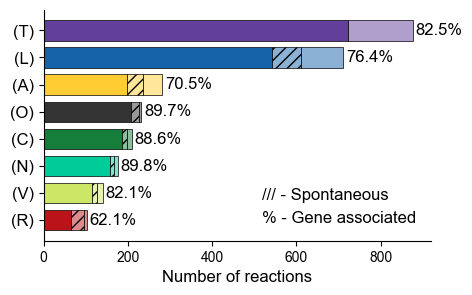

In [14]:
df = df_reactions.copy()

fontsize = 12
percentage_col = "Gene associated"
only_total = False
colormaps_dict = {
    "Gene associated": colormaps_normal,
    "Spontaneous": colormaps_light,
    "Unknown": colormaps_light,
}
hatches_dict = {
    "Gene associated": None,
    "Spontaneous": "///",
    "Unknown": None,
}
barsize = 0.75
edgecolor = "black"
edgewidth = 0.5
padding = 2
barchart_figsize = (5, 3)

fig_reactions, ax_rxns = plt.subplots(1, 1, figsize=barchart_figsize)
sns.despine(fig_reactions)

offset = np.zeros(len(df.index))
columns_to_plot = (
    ["Total"] if only_total else [col for col in df.columns if col != "Total"]
)
for idx, (label, series) in enumerate(df[columns_to_plot].items()):
    rects = ax_rxns.barh(
        [
            f"({abbrevs.get(x)})" if abbrevs.get(x) and use_abbrevs else x
            for x in series.index
        ],
        series.values,
        height=barsize,
        hatch=hatches_dict.get(label, None),
        left=offset,
        label=f"% - {percentage_col}",
        color=[colormaps_dict.get(label, colormaps_normal)[k] for k in series.index],
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values

percents = [
    "{:,.1f}%".format(v) for v in 100 * (df[percentage_col] / df["Total"]).values
]
ax_rxns.bar_label(
    rects,
    labels=percents,
    label_type="edge",
    color="black",
    padding=padding,
    fontsize=fontsize,
)
ax_rxns.legend(
    handles=[
        mpl.patches.Patch(color="white"),
        mpl.patches.Patch(color="white"),
    ],
    labels=["/// - Spontaneous", f"% - {percentage_col}"],
    frameon=False,
    loc="lower right",
    fontsize=fontsize,
)
ax_rxns.set_xlabel("Number of reactions", fontsize=fontsize)
ax_rxns.yaxis.set_tick_params(labelsize=fontsize)
if save_figures:
    fig_reactions.savefig(
        results_path / f"ModelContent_PanelC.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Metabolite content

In [15]:
df_metabolites = defaultdict(dict)

for category in categories_to_keep:
    metabolites = data[category]["Metabolites"]
    # metabolites = set([met for met in metabolites if met.compartment != "e"])
    # Genes that are not unique to one category
    shared = {
        x
        for x in metabolites
        if any(
            [
                set(x.reactions).intersection(data[cat]["Reactions"])
                for cat in data.keys()
                if cat != category
            ]
        )
    }
    unique = {x for x in metabolites if not x in shared}
    df_metabolites[category]["Shared"] = len(shared)
    df_metabolites[category]["Unique"] = len(unique)
    df_metabolites[category]["Total"] = len(metabolites)

    df_metabolites[category]["Shared.ids"] = build_string(
        sorted([x.id for x in shared])
    )
    df_metabolites[category]["Unique.ids"] = build_string(
        sorted([x.id for x in unique])
    )

# To DataFrame
df_metabolites = pd.DataFrame.from_dict(df_metabolites).T
if use_abbrevs:
    df_metabolites["abbrevs"] = abbrevs
# QC check to ensure no genes are missing
assert (
    df_metabolites[["Shared", "Unique"]].sum(axis=1) == df_metabolites["Total"]
).all()
df_metabolites = df_metabolites.sort_values(by="Total", ascending=True)
all_figure_data["Metabolites"] = df_metabolites.copy()
df_metabolites = df_metabolites.drop(
    labels=[c for c in df_metabolites.columns if c.endswith(".ids") or c == "abbrevs"],
    axis=1,
).astype(int)
df_metabolites

,Shared,Unique,Total
Reactive species,81,46,127
Nucleotide metabolism,84,62,146
Metabolism of cofactors and vitamins,100,76,176
Carbohydrate metabolism,108,99,207
Amino acid metabolism,131,145,276
Other,108,254,362
Lipid metabolism,234,506,740
Transport reactions,444,446,890


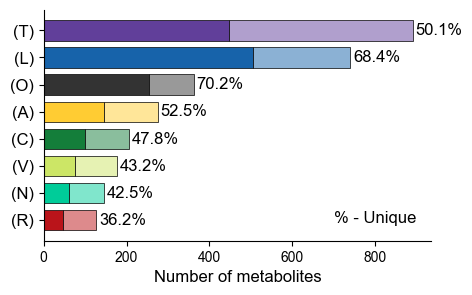

In [16]:
df = df_metabolites.copy()

fontsize = 12
percentage_col = "Unique"
only_total = False
colormaps_dict = {
    "Unique": colormaps_normal,
    "Shared": colormaps_light,
    "Total": colormaps_normal,
}
hatches_dict = {}
barsize = 0.75
edgecolor = "black"
edgewidth = 0.5
padding = 2
barchart_figsize = (5, 3)

fig_metabolites, ax_mets = plt.subplots(1, 1, figsize=barchart_figsize)
sns.despine(fig_metabolites)

offset = np.zeros(len(df.index))
columns_to_plot = ["Total"] if only_total else ["Unique", "Shared"]
for idx, (label, series) in enumerate(df[columns_to_plot].items()):
    rects = ax_mets.barh(
        [
            f"({abbrevs.get(x)})" if abbrevs.get(x) and use_abbrevs else x
            for x in series.index
        ],
        series.values,
        height=barsize,
        hatch=hatches_dict.get(label, None),
        left=offset,
        label=f"% - {percentage_col}",
        color=[colormaps_dict.get(label, colormaps_normal)[k] for k in series.index],
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values

percents = [
    "{:,.1f}%".format(v) for v in 100 * (df[percentage_col] / df["Total"]).values
]
ax_mets.bar_label(
    rects,
    labels=percents,
    label_type="edge",
    color="black",
    padding=padding,
    fontsize=fontsize,
)
ax_mets.legend(
    handles=[
        mpl.patches.Patch(color="white"),
        mpl.patches.Patch(color="white"),
    ],
    labels=[f"% - {percentage_col}"],
    frameon=False,
    loc="lower right",
    fontsize=fontsize,
)
ax_mets.set_xlabel("Number of metabolites", fontsize=fontsize)
ax_mets.yaxis.set_tick_params(labelsize=fontsize)
if save_figures:
    fig_metabolites.savefig(
        results_path / f"ModelContent_PanelD.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Gene content

In [17]:
df_genes = defaultdict(dict)

for category in categories_to_keep:
    genes = data[category]["Genes"]
    # Genes that are not unique to one category
    shared = {
        x
        for x in genes
        if any(
            [
                set(x.reactions).intersection(data[cat]["Reactions"])
                for cat in data.keys()
                if cat != category
            ]
        )
    }
    unique = {x for x in genes if not x in shared}
    df_genes[category]["Shared"] = len(shared)
    df_genes[category]["Unique"] = len(unique)
    df_genes[category]["Total"] = len(genes)

    df_genes[category]["Shared.ids"] = build_string(sorted([x.id for x in shared]))
    df_genes[category]["Unique.ids"] = build_string(sorted([x.id for x in unique]))

# To DataFrame
df_genes = pd.DataFrame.from_dict(df_genes).T
if use_abbrevs:
    df_genes["abbrevs"] = abbrevs
# QC check to ensure no genes are missing
assert (df_genes[["Shared", "Unique"]].sum(axis=1) == df_genes["Total"]).all()
df_genes = df_genes.sort_values(by="Total", ascending=True)
all_figure_data["Genes"] = df_genes.copy()
df_genes = df_genes.drop(
    labels=[c for c in df_genes.columns if c.endswith(".ids") or c == "abbrevs"], axis=1
).astype(int)
df_genes

,Shared,Unique,Total
Reactive species,29,8,37
Metabolism of cofactors and vitamins,29,40,69
Amino acid metabolism,52,48,100
Lipid metabolism,37,69,106
Nucleotide metabolism,37,90,127
Carbohydrate metabolism,37,111,148
Transport reactions,4,146,150
Other,41,197,238


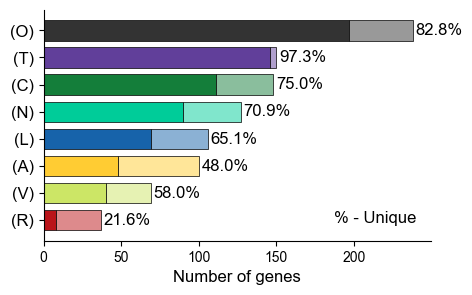

In [18]:
df = df_genes.copy()

fontsize = 12
percentage_col = "Unique"
only_total = False
colormaps_dict = {
    "Unique": colormaps_normal,
    "Shared": colormaps_light,
    "Total": colormaps_normal,
}
hatches_dict = {}
barsize = 0.75
edgecolor = "black"
edgewidth = 0.5
padding = 2
barchart_figsize = (5, 3)

fig_genes, ax_genes = plt.subplots(1, 1, figsize=barchart_figsize)
sns.despine(fig_genes)

offset = np.zeros(len(df.index))
columns_to_plot = ["Total"] if only_total else ["Unique", "Shared"]
for idx, (label, series) in enumerate(df[columns_to_plot].items()):
    rects = ax_genes.barh(
        [
            f"({abbrevs.get(x)})" if abbrevs.get(x) and use_abbrevs else x
            for x in series.index
        ],
        series.values,
        height=barsize,
        hatch=hatches_dict.get(label, None),
        left=offset,
        label=f"% - {percentage_col}",
        color=[colormaps_dict.get(label, colormaps_normal)[k] for k in series.index],
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values

percents = [
    "{:,.1f}%".format(v) for v in 100 * (df[percentage_col] / df["Total"]).values
]
ax_genes.bar_label(
    rects,
    labels=percents,
    label_type="edge",
    color="black",
    padding=padding,
    fontsize=fontsize,
)
ax_genes.legend(
    handles=[
        mpl.patches.Patch(color="white"),
        mpl.patches.Patch(color="white"),
    ],
    labels=[f"% - {percentage_col}"],
    frameon=False,
    loc="lower right",
    fontsize=fontsize,
)
ax_genes.set_xlabel("Number of genes", fontsize=fontsize)
ax_genes.yaxis.set_tick_params(labelsize=fontsize)
if save_figures:
    fig_genes.savefig(
        results_path / f"ModelContent_PanelE_{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

## Export Figures and Data

In [19]:
print(all_figure_data.keys())
with pd.ExcelWriter(results_path / f"ModelContentOverviewData.xlsx") as writer:
    for sheet_name, df in all_figure_data.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

dict_keys(['PathwayMapping', 'General', 'Subsystem Sizes', 'Category Sizes', 'Transporters_class', 'Reactions', 'Metabolites', 'Genes'])


### Aggregate Panels for visualization

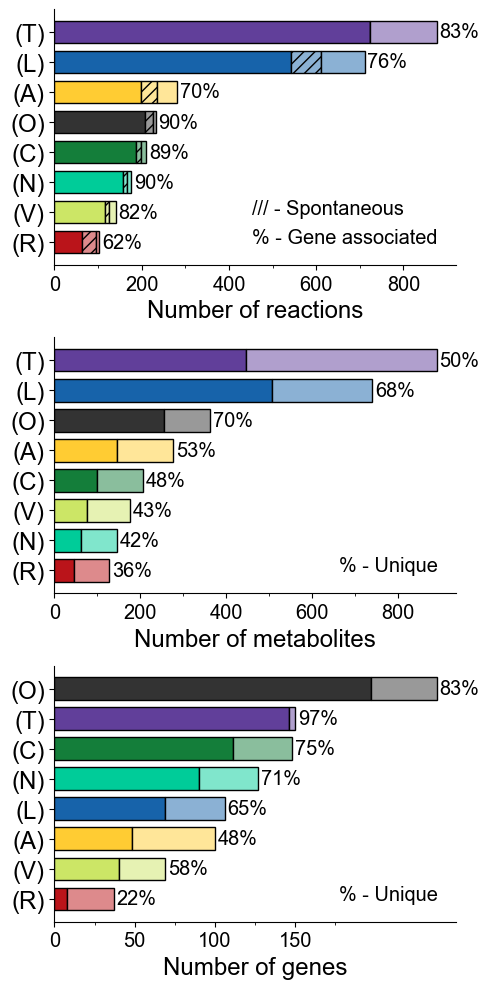

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
sns.despine(fig)
(ax_rxns, ax_mets, ax_genes) = axes.flatten()


only_total = False
barsize = 0.75
edgecolor = "black"
edgewidth = 1
padding = 2
barchart_figsize = (5, 3)


## Reaction content
df = df_reactions.copy()
percentage_col = "Gene associated"
colormaps_dict = {
    "Gene associated": colormaps_normal,
    "Spontaneous": colormaps_light,
    "Unknown": colormaps_light,
}
hatches_dict = {
    "Gene associated": None,
    "Spontaneous": "///",
    "Unknown": None,
}

offset = np.zeros(len(df.index))
columns_to_plot = (
    ["Total"] if only_total else [col for col in df.columns if col != "Total"]
)
for idx, (label, series) in enumerate(df[columns_to_plot].items()):
    rects = ax_rxns.barh(
        [
            f"({abbrevs.get(x)})" if abbrevs.get(x) and use_abbrevs else x
            for x in series.index
        ],
        series.values,
        height=barsize,
        hatch=hatches_dict.get(label, None),
        left=offset,
        label=f"% - {percentage_col}",
        color=[colormaps_dict.get(label, colormaps_normal)[k] for k in series.index],
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values

ax_rxns.bar_label(
    rects,
    labels=[
        "{:,.0f}%".format(v) for v in 100 * (df[percentage_col] / df["Total"]).values
    ],
    label_type="edge",
    color="black",
    padding=padding,
    fontsize="x-large",
)
ax_rxns.legend(
    handles=[
        mpl.patches.Patch(color="white"),
        mpl.patches.Patch(color="white"),
    ],
    labels=["/// - Spontaneous", f"% - {percentage_col}"],
    frameon=False,
    loc="lower right",
    fontsize="x-large",
)
attribute_type = "reactions"
ax_rxns.set_xlabel(f"Number of {attribute_type}", fontsize="xx-large")
ax_rxns.xaxis.set_tick_params(labelsize="x-large")
ax_rxns.set_xticks([0, 200, 400, 600, 800], minor=False)
ax_rxns.set_xticks([100, 300, 500, 700], minor=True)
ax_rxns.yaxis.set_tick_params(labelsize="xx-large")


## Metabolite content
df = df_metabolites.copy()
percentage_col = "Unique"
colormaps_dict = {
    "Unique": colormaps_normal,
    "Shared": colormaps_light,
    "Total": colormaps_normal,
}
hatches_dict = {}

offset = np.zeros(len(df.index))
columns_to_plot = ["Total"] if only_total else ["Unique", "Shared"]
for idx, (label, series) in enumerate(df[columns_to_plot].items()):
    rects = ax_mets.barh(
        [
            f"({abbrevs.get(x)})" if abbrevs.get(x) and use_abbrevs else x
            for x in series.index
        ],
        series.values,
        height=barsize,
        hatch=hatches_dict.get(label, None),
        left=offset,
        label=f"% - {percentage_col}",
        color=[colormaps_dict.get(label, colormaps_normal)[k] for k in series.index],
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values

ax_mets.bar_label(
    rects,
    labels=[
        "{:,.0f}%".format(v) for v in 100 * (df[percentage_col] / df["Total"]).values
    ],
    label_type="edge",
    color="black",
    padding=padding,
    fontsize="x-large",
)
ax_mets.legend(
    handles=[
        mpl.patches.Patch(color="white"),
        mpl.patches.Patch(color="white"),
    ],
    labels=[f"% - {percentage_col}"],
    frameon=False,
    loc="lower right",
    fontsize="x-large",
)
attribute_type = "metabolites"
ax_mets.set_xlabel(f"Number of {attribute_type}", fontsize="xx-large")
ax_mets.xaxis.set_tick_params(labelsize="x-large")
ax_mets.set_xticks([0, 200, 400, 600, 800], minor=False)
ax_mets.set_xticks([100, 300, 500, 700], minor=True)
ax_mets.yaxis.set_tick_params(labelsize="xx-large")


## Gene content
df = df_genes.copy()
percentage_col = "Unique"
colormaps_dict = {
    "Unique": colormaps_normal,
    "Shared": colormaps_light,
    "Total": colormaps_normal,
}
hatches_dict = {}

offset = np.zeros(len(df.index))
columns_to_plot = ["Total"] if only_total else ["Unique", "Shared"]
for idx, (label, series) in enumerate(df[columns_to_plot].items()):
    rects = ax_genes.barh(
        [
            f"({abbrevs.get(x)})" if abbrevs.get(x) and use_abbrevs else x
            for x in series.index
        ],
        series.values,
        height=barsize,
        hatch=hatches_dict.get(label, None),
        left=offset,
        label=f"% - {percentage_col}",
        color=[colormaps_dict.get(label, colormaps_normal)[k] for k in series.index],
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values

ax_genes.bar_label(
    rects,
    labels=[
        "{:,.0f}%".format(v) for v in 100 * (df[percentage_col] / df["Total"]).values
    ],
    label_type="edge",
    color="black",
    padding=padding,
    fontsize="x-large",
)
ax_genes.legend(
    handles=[
        mpl.patches.Patch(color="white"),
        mpl.patches.Patch(color="white"),
    ],
    labels=[f"% - {percentage_col}"],
    frameon=False,
    loc="lower right",
    fontsize="x-large",
)
attribute_type = "genes"
ax_genes.set_xlabel(f"Number of {attribute_type}", fontsize="xx-large")
ax_genes.xaxis.set_tick_params(labelsize="x-large")
ax_genes.set_xticks([0, 50, 100, 150], minor=False)
ax_genes.set_xticks([25, 75, 125, 175], minor=True)
ax_genes.yaxis.set_tick_params(labelsize="xx-large")
fig.align_ylabels([ax_rxns, ax_mets, ax_genes])
fig.tight_layout()
if save_figures:
    fig.savefig(
        results_path / f"ModelContent_PanelCDE.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;